Code from 6/4/20


In [ ]:
## Leave commented out if already done
# pip install Pillow

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# wait a min, then look at the file explorer to the left and find the alz dataset, capy the paths for train/test into the import data cell below

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# from sklearn.model_selection import KFold

start = time.time()

# Variables

In [3]:
## variables for the fiddling with (95% val_acc with .13 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters) [.8,.8]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = False        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 15                      # number of epochs to run                                             100
momentum = .9                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)

# k_folds = 10                # number of folds for k-fold validation                              #k-folds someday

val20_epochs15


# Import Data From Local Drive

In [4]:
# INSTRUCTIONS FOR USING COLAB

In [5]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

#CHANGE PATH TO TRAINING DATASET HERE
train_data_gen = train_dr.flow_from_directory(directory="/content/gdrive/MyDrive/Alzheimer_s_Dataset/train",target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
#CHANGE PATH TO TEST DATASET HERE
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="/content/gdrive/MyDrive/Alzheimer_s_Dataset/test",target_size=dim,batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [6]:
# This section assigns the images to numpy arrays for the data and labels, and takes a long time on colab
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [7]:
# cocatenate arrays, combining all data 
# test data and training data are not from the same part of the brain so we need to combine the data 
# need to join the entire data 
# training got one part of brain and test got another 
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [8]:
# train test split
# split the combined data set into two different random piles

initial_split = test_split_percent+validation_split_percent  # 30% of total
test_val_split = test_split_percent/initial_split  # 1/3 = 33% of the initial split

# (Original) split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels, test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

# # (New 4 sets) split into 4 training sets 1-4 of 4
# # can experiment with https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

# train_data75, train_data_1of4, train_data75_labels, train_data_1of4_labels = train_test_split(train_data, train_labels, test_size=.25)
# train_data50, train_data_2of4, train_data50_labels, train_data_2of4_labels = train_test_split(train_data75, train_data75_labels, test_size=.33)
# train_data_3of4, train_data_4of4, train_data_3of4_labels, train_data_4of4_labels = train_test_split(train_data50, train_data50_labels, test_size=.5)


# print('train: ',train_data.shape)
# print('validation',val_data.shape)
# print('test',test_data.shape)

# print('train 1 of 4: ',train_data_1of4.shape)
# print('train 2 of 4: ',train_data_2of4.shape)
# print('train 3 of 4: ',train_data_3of4.shape)
# print('train 4 of 4: ',train_data_4of4.shape)


In [9]:
# split training data into smaller sets (4)?

# Sanity Checks

In [10]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


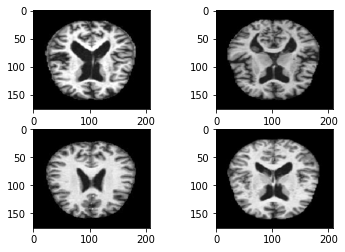

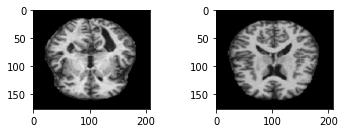

In [11]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [12]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


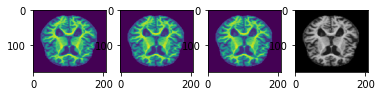

In [13]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model, (or skip down and load one)
to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import standard VGG16 model for training

vg_model = VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15
                          
# [test loss, test acc] return from keras.evaluate
scores = vg_model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

# Plots and Values

In [ ]:
# plot accuracy

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# print(np.amax.model_history.history['val_acc'])

#Plot loss
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# print out variable values
print('image dimensions: ',dim)
print('validation split percentage: ',validation_split_percent)
print('zoom: ',zoom)
print('Learning Rate: ',lr)
print('batch size: ',batch)
print('epochs: ',eps)
print('brightness range: ',bright_range)
print('Model trained from scratch? : ',layers_unlocked)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

# Load Model, RESTART HERE AFTER FIRST RUN

In [14]:
## choose the model to load ##
## comment out when not using ##

vg_model = load_model("/content/gdrive/MyDrive/ECE 269 COLAB/Combine/val20_epochs10_START_testacc82.h5") 


In [15]:
#  RETRAIN

In [16]:
# NEW TEST

# Performance Evaluation
Come here after loading model

In [17]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 5s 121ms/step - loss: 0.3347 - accuracy: 0.8933
Train Accuracy: 88.99%
Validation Accuracy: 85.67%
Test Accuracy: 89.33%


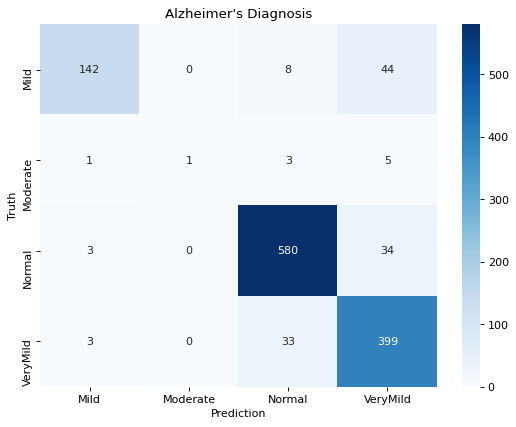

In [18]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
# evaluate_most_confused_labels(confusion_matrix)
# GENERATE NEW TRAINING SET AND TEST


# Saving the Model

In [ ]:
## saving in HDF5 format (uncomment below to save model)
gdrive_path = '/content/gdrive/MyDrive/ECE 269 COLAB'
save_name = '%s_testacc%2d.h5'%(save_model_name,(test_scores[1]*100))
gdrive_savename = gdrive_path + '/' + save_name
vg_model.save(gdrive_savename)
print(gdrive_savename)


## save the model_history
